# 1. Introduction 

Collateral Reblance Pool (CRP) dynamically rebalances Collateral to ensure the ayToken minted (i.e. the loan) remains solvent, especially in an adverse market environment (i.e. the value of the loan does not exceed the value of Collateral). This dynamic rebalancing, together with a careful choice of the key parameters (including loan to Loan-to-Value (LTV) and volatility assumption) allows ALEX to eliminate the liquidation needs. Any residual gap risk (which CRP cannot address entirely) is addressed through maintaining a strong reserve fund. When a Borrower mints ayToken by providing appropriate Collateral, the Collateral is converted into a basket of Collateral and Token, with the weights determined by CRP.

In this notebook, we will help you understand the key attributes of the CRP pool by answering: 
1.  How does CRP achieve the dynamic rebalances with weights determined by CRP? 
2.  How does CRP perform in different market environments? 
3.  How does power arbitrageur play a role in the dynamic rebalances and the bring rebate back to the pool.   
3.  In which parameters space (including LTV, volatility assumption, and power arbitrageur functions) and the CRP would maintain a low default risk and a high pool-value level to a collateral ratio (PVCR)?  

Given there is no close form of CPR performance, we use simulation to show the results based on the predicted future scenarios.  


# 2. CRP dynamic rebalance mechanism 

The following diagram illustrates how CRP dynamic rebalances with the weights determined by CRP.  Once the pool updates new weights based on the Black-Scholes option-pricing model, the pool will be rebalanced by Power Arbitrageur to bring the spot price back to the market price. We leave the mathematical formula of the weight to session 5.    
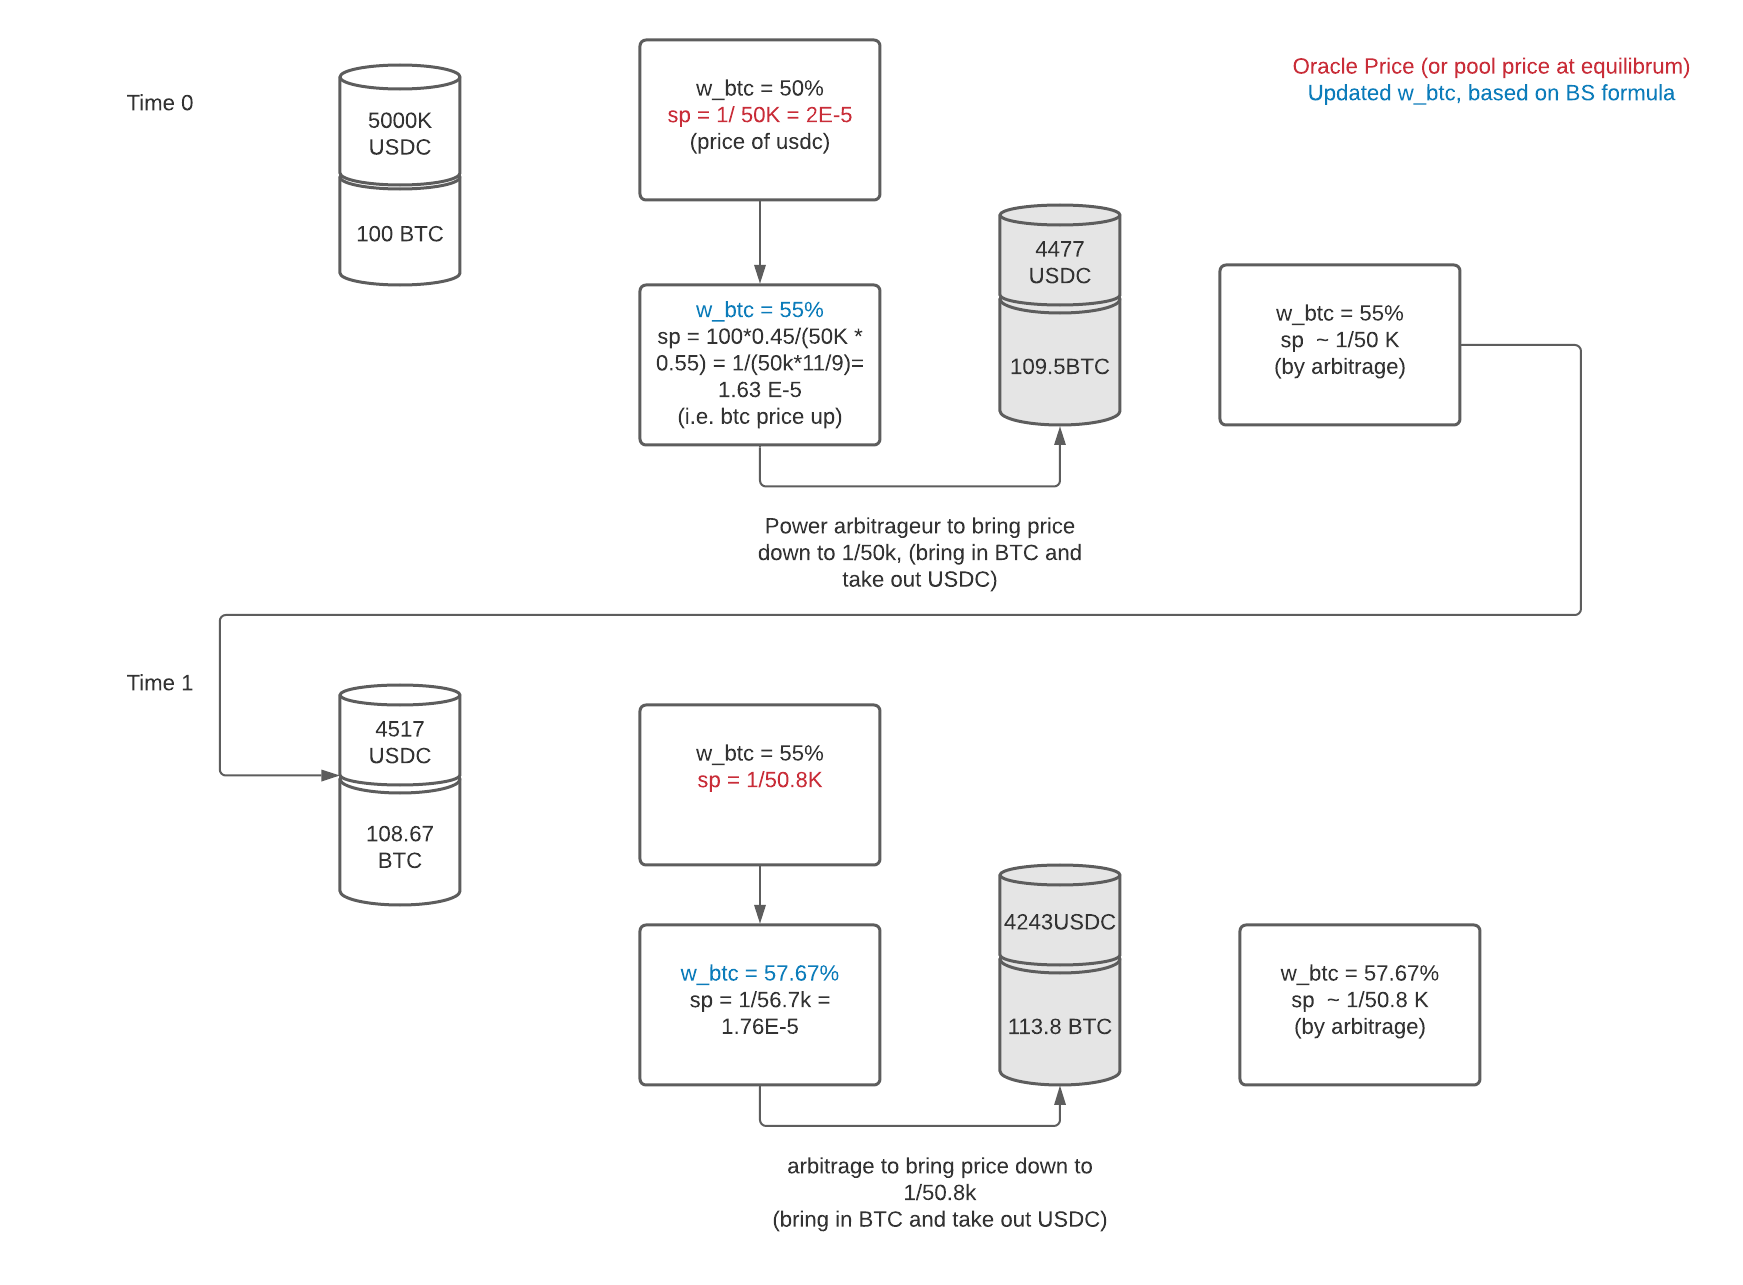


# 3.  CRP performance by Simulations  

In this session, we want to simulate how CRP performs in different market environments.  Basically, a CRP would serve as an agent (bot) response to the actual market environment by updating the pool weight based on current token price $p$, actual price volatility $\eta$, and estimated price volatility $\sigma$.  We simplify the market environment and let the token price change follow a linear growth trend with variation, formally named the Geometric Brownian Motion (https://en.wikipedia.org/wiki/Geometric_Brownian_motion).  By setting up different growth rates $r$ and volatility $\eta$, we can approximately mimic different market environments.  

Two metrics a liquidity provider (LP) would be very interested to know are 1) the chance of default, i.e., when the LtV >1 at any time point, and 2) Impermanent loss.  We can empirically estimate the default risk and confidence intervals of impermanent loss for any given parameters by conducting Monte Carlo simulations. 

For simplicity, token APY are not considered for now. We set initial weights to be 50/50 and loan lifetime equals 91 days, and all key parameters various in the following parameters space: 
### Pool parameters 

   (1) Initial LTV: range from 0.7 to 0.95
    
   (2) Black-scholes volatility: $\sigma$ range from 0.1 - 1.0  
   
   (3) Rebate rate of the power arbitargeur: 0 - 100% 
   
   (4) Fee paid based on percentage to weights change: 0% - 1% 
   
   (5) Moving average (MA) of rebalnacing weights: 1 - 30 

### Market enviroment        
   (6) Growth rate: $r$ range from $[-2, 2]$ (corresponding to 25% or 200% of the initial price)
   
   (7) Growth rate volatility: $\eta$ range from 0.1 - 1.0
   
  

### Episode 

For each parameter setup (1) to (7), we activate the CRP and monitor its performance during the whole loan life term (called an episode). At each scheduled time point t (e.g. daily), we rebalance Collateral and token according to section 5, and record and plot:

1. Token price at time t 
2. Reblanced weight at time t 
3. LTV (pool value includes rebate and fee)   
4. PVTC (pool value includes rebate and fee) 
5. Scatter plot of BTC weight change and impermanent loss ratio.   

Each episode will be one realization of the CRP based on the selected parameters. 



In [1]:
# plot of liquity 
import scipy 
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.widgets import Slider
import seaborn as sns
import numpy as np 
import random
import pandas as pd 
from ipywidgets import *
from scipy.stats import norm

#Import simulation function and class 
%run rbpool_env_v2.ipynb

In [2]:
# an episode example  
t =  np.linspace(91,0,92)/365
Real_vol = 0.5
Growth_rate = 1
LTV0 = 0.8
bs_vol = 0.5
y_price_init = 50000
Collateral = 10000000
pool_init_x = 5000000 
pool_init_y = 100
pool_init_wx = 0.5
fee_rate = 0.0015
rebate=0.8
set_random_seed = True 

example = get_episode_full(t,y_price_init, bs_vol, Growth_rate, Real_vol, Collateral, LTV0, fee_rate, rebate,
                      pool_init_x, pool_init_y, pool_init_wx, ma_window=3)
example.head(2)

,t,y_price,weights_ytoken,slippage_rebalance,x_locked,y_locked,coll_with_rebate,btc_bal,usd_bal,collateral_value,splippage_check,ltv_rebalance,ltv_with_rebate,wt_chg,pvtc_rebate
0,0.249315,50000.000000,0.549670,0.000000,4.503296e+06,5.496704e+06,1.000000e+07,5.496704e+06,4.503296e+06,1.000000e+07,0.000000,0.800000,0.800000,0.000000,1.000000
1,0.246575,50173.968817,0.554931,-0.000056,4.459184e+06,5.559908e+06,1.001909e+07,5.559556e+06,4.459024e+06,1.001858e+07,-0.000039,0.798516,0.798476,0.005261,0.998435


<IPython.core.display.Javascript object>


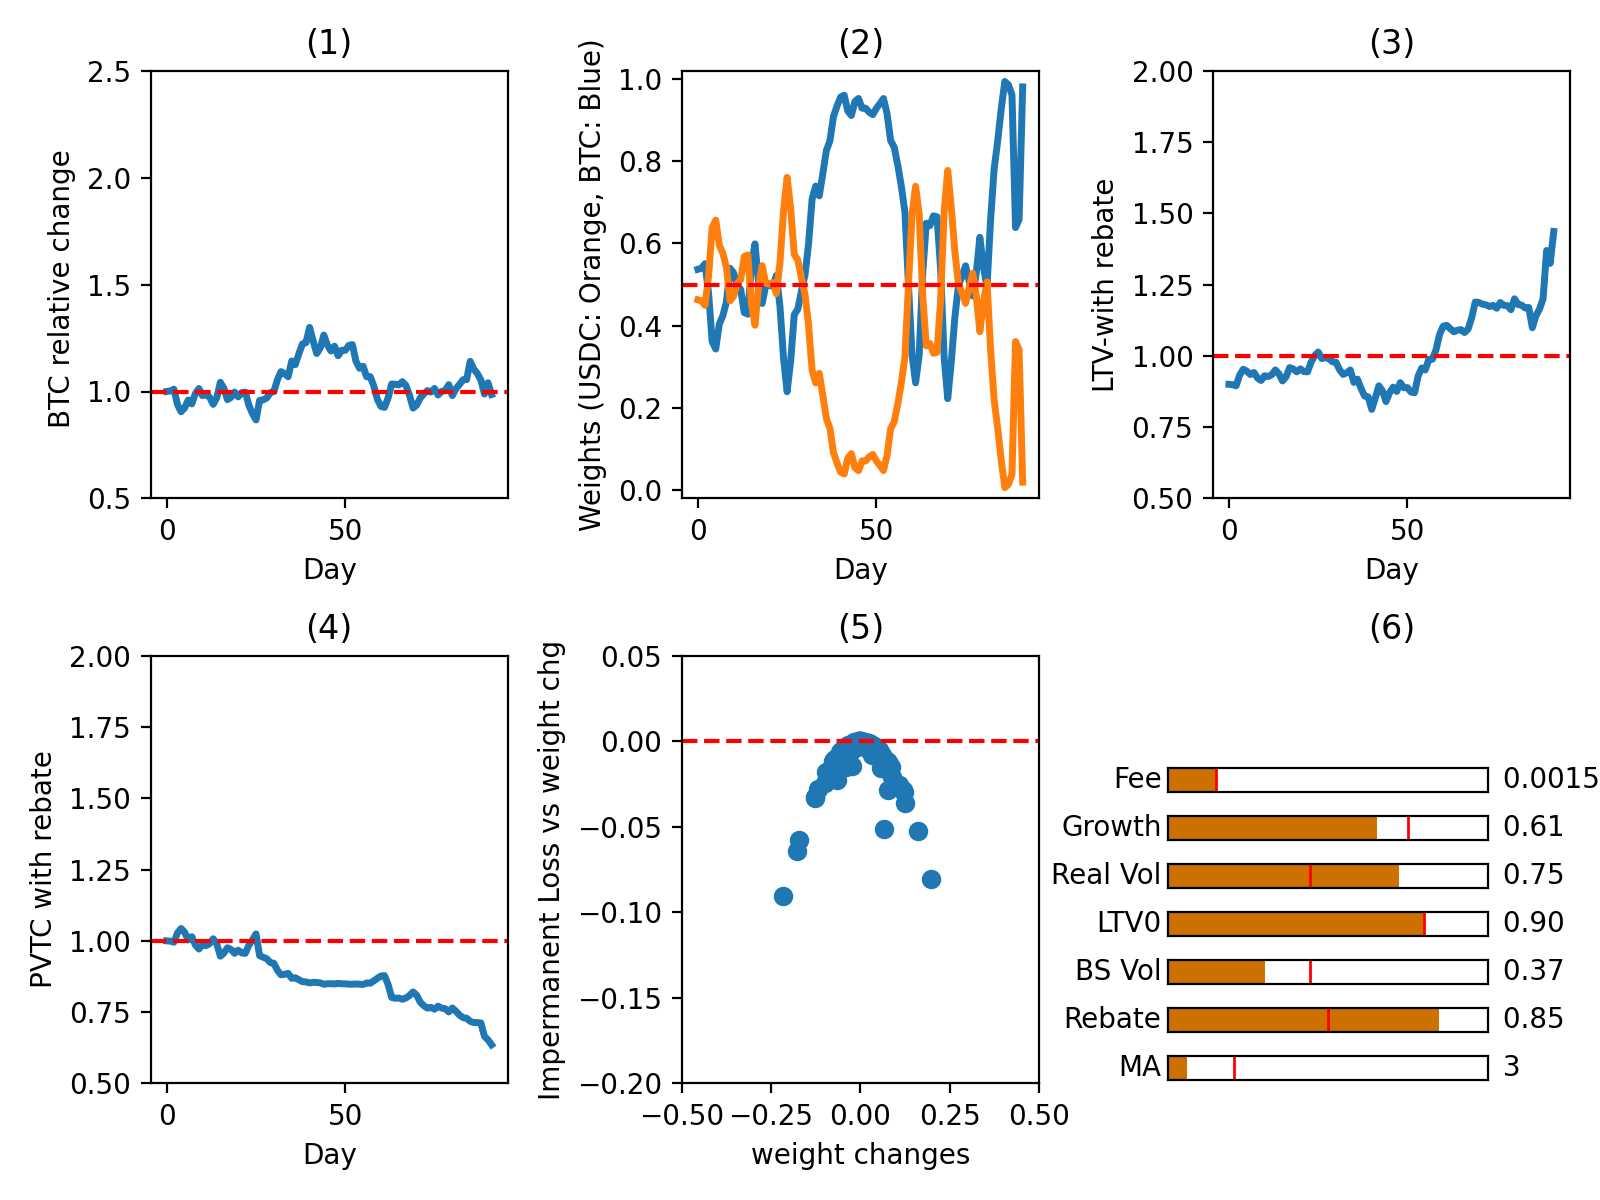

C:\Users\jings\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [3]:
 # fix random seed for rw.  
# plot key metrics 
episode_plot(['y_price', 'weights_ytoken', 'ltv_with_rebate', 'pvtc_rebate', 'slippage_rebalance', 'wt_chg'])


# 4 Simulation findings 


Example 1: In the market, when BTC price goes up (above fig), with 50% rebate on power arbitrageur profit, the CRP maintains LTV lower than 0.8 and PVTC is more than 80% of the initial Collateral.  



Example 2: In the market, when BTC price goes down to more than 50%, with 50% rebate on power arbitrageur profit, the CRP maintains LTV < 1 and PVTC greater than Collateral.  


   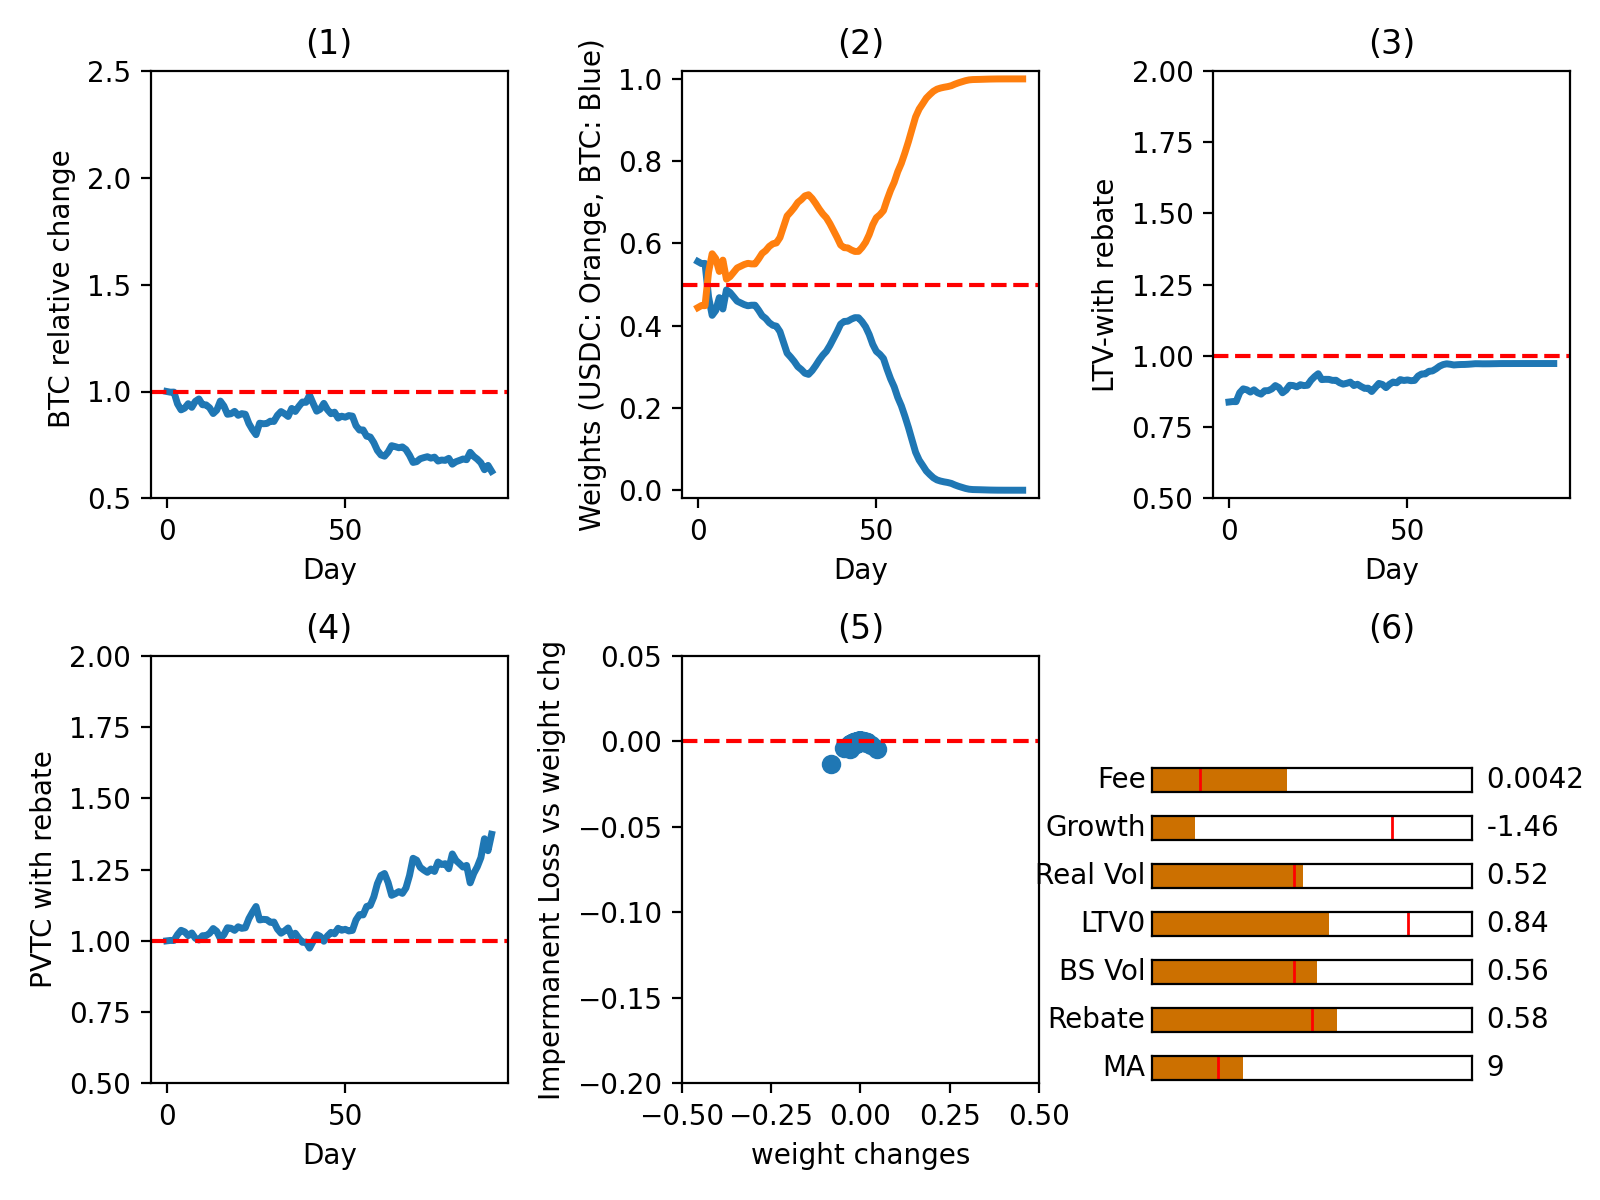



# 5 How CRP determine the weights 

Let $P_0$ and $P_t$ be the token price at time 0 and time $t$, respectively. CRP determines the weights based on the prevailing LTV and uses the following formula:

\begin{equation}
   \begin{cases}
      w_{Token} = N(d_1) \\
      w_{Collateral} = (1 - w_{Token}) \\
      d_1 = \frac{1}{\sigma \sqrt{(t)}} [ln (\frac{P_t}{P_0}) + t \cdot \frac{\sigma^2}{2}] 
    \end{cases}       
    \label{eq:CRP} \tag{1} 
\end{equation}

Where $N()$ is cdf of standard normal distribution, some readers may note the similarity of the above formula to the Black & Scholes delta because it is. CRP essentially implements a delta replicating strategy of a call option on Token / Collateral, buying more Token when LTV moves higher and vice versa.

Token price changes follow: 
$$ log(P_t) = log(P_0) + (r - \frac{\eta^2}{2}) \cdot \Delta t + \eta W_t $$
where $W_t$ is a Brownian motion. 


    

